In [33]:
from datacube import Datacube
# from matplotlib import pyplot as plt
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
from datacube_stats.statistics import GeoMedian
cdc = Datacube(config='/g/data/u46/users/ext547/ewater/cambodia_cube/cambodia.conf')
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict

In [35]:
test= cdc.load(product='ls_level2_geomedian_annual',**query)
# test= test.squeeze()
test

<xarray.Dataset>
Dimensions:  (time: 3, x: 365, y: 372)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2016-01-01 2017-01-01
  * y        (y) float64 1.449e+06 1.449e+06 1.449e+06 1.449e+06 1.449e+06 ...
  * x        (x) float64 3.156e+05 3.156e+05 3.157e+05 3.157e+05 3.157e+05 ...
Data variables:
    blue     (time, y, x) int16 858 804 773 849 814 765 740 731 743 748 786 ...
    green    (time, y, x) int16 1290 1190 1186 1238 1207 1131 1096 1123 1146 ...
    red      (time, y, x) int16 1664 1519 1480 1594 1515 1417 1365 1360 1393 ...
    nir      (time, y, x) int16 2821 2668 2791 2812 2737 2700 2603 2571 2499 ...
    swir1    (time, y, x) int16 3820 3634 3637 3874 3708 3599 3503 3366 3264 ...
    swir2    (time, y, x) int16 2679 2502 2464 2657 2479 2320 2208 2117 2117 ...
Attributes:
    crs:      EPSG:32648

In [24]:
# set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. 
# Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.20


lat_min = 13.000 #down
lat_max = 13.100 #up
lon_min = 103.300 #left
lon_max = 103.400 #right  


#define temporal range ()
start_of_epoch = '2015-01-01'
end_of_epoch =  '2018-01-01'

#define first time of interest
start_of_time01 = '2015-01-01'
end_of_time01 = '2016-05-01'

#define second time of interest
start_of_time02 = '2016-05-02'
end_of_time02 = '2017-12-31'

#define wavelengths/bands of interest
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'pixel_qa',
                     #'swir2',
                     ]

#define Landsat sensors of interest
sensors = ['ls8',]
#        'ls7',] 

#query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2015-01-01', '2018-01-01'), 'x': (103.3, 103.4), 'y': (13.1, 13.0), 'crs': 'EPSG:4326'}


In [23]:
def three_band_image(ds, bands,title,figsize = [10,10]):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an 
    image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause and Erin Telfer
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    '''
    rgb = ds.to_array(dim='color').sel(color=bands).transpose('y', 'x', 'color')
    fake_saturation = 6000.0
    rgb = rgb.astype('double')
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    print(type(clipped_visible))
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)

    fig = plt.figure(figsize = figsize)
    plt.title(title, fontsize=16)
    plt.imshow(scaled)

<class 'xarray.core.dataarray.DataArray'>


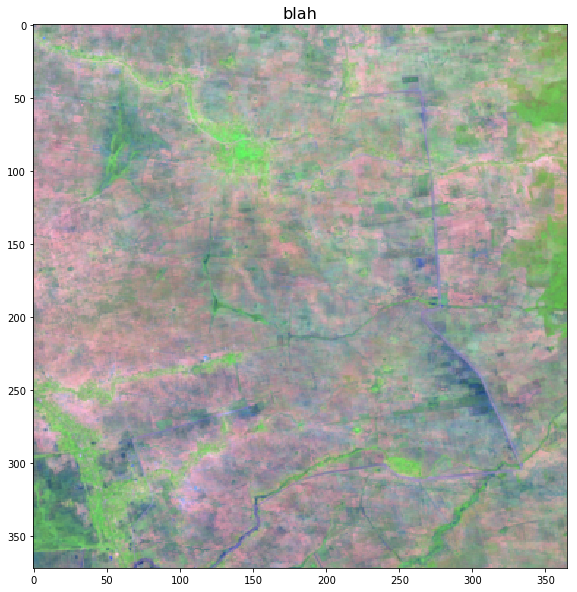

In [29]:
three_band_image(test, ['swir1','nir', 'green'], 
                 title='blah')

In [21]:
def three_band_image_subplots(ds, bands, num_cols, figsize = [10,10], 
                              projection = 'projected', left  = 0.125, 
                              right = 0.9, bottom = 0.1, top = 0.9, 
                              wspace = 0.2, hspace = 0.4):
    '''
    threeBandImage_subplots takes three spectral bands and multiple time steps, 
    and plots them on the RGB bands of an image. 
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    num_cols - number of columns for the subplot
    
    Optional:
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image 
                 is in degrees or northings
    left  - the space on the left side of the subplots of the figure
    right - the space on the right side of the subplots of the figure
    bottom - the space on the bottom of the subplots of the figure
    top - the space on the top of the subplots of the figure
    wspace - the amount of width reserved for blank space between subplots
    hspace - the amount of height reserved for white space between subplots
    '''
    # Find the number of rows/columns we need, based on the number of time steps in ds
    timesteps = ds.time.size
    num_rows = int(np.ceil(timesteps/num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    fig.subplots_adjust(left  = left, right = right, bottom = bottom, top = top, 
                        wspace = wspace, hspace = hspace)
    numbers = 0
    try:
        for ax in axes.flat:
            t, y, x = ds[bands[0]].shape
            rawimg = np.zeros((y,x,3), dtype = np.float32)
            for i, colour in enumerate(bands):
                rawimg[:,:,i] = ds[colour][numbers].values
            rawimg[rawimg == -999] = np.nan
            img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
            ax.imshow(img_toshow)
            ax.set_title(str(ds.time[numbers].values)[:10], fontweight = 'bold', fontsize = 12)
#             ax.set_xticklabels(ds.x.values, fontsize = 8, rotation = 20)
#             ax.set_yticklabels(ds.y.values, fontsize = 8)
#             if projection == 'geographic':
#                 ax.set_xlabel('Longitude', fontweight = 'bold', fontsize = 10)
#                 ax.set_ylabel('Latitude', fontweight = 'bold', fontsize = 10)
#             else:
#                 ax.set_xlabel('Eastings', fontweight = 'bold', fontsize = 10)
#                 ax.set_ylabel('Northings', fontweight = 'bold', fontsize = 10)
            numbers = numbers + 1
    except IndexError:
        # This error will pop up if there are not enough scenes to fill the number of 
        # rows x columns, so we can safely ignore it
        fig.delaxes(ax)
        plt.draw()    

In [28]:
# three_band_image_subplots(test, ['red','green','blue'], 2, figsize = [30,50])

In [34]:
# cdc.list_products()
cdc.list_measurements()

aliases  \
product                    measurement                                              
ls7_usgs_sr_scene          blue                                [band_1, sr_band1]   
                           green                               [band_2, sr_band2]   
                           red                                 [band_3, sr_band3]   
                           nir                                 [band_4, sr_band4]   
                           swir1                               [band_5, sr_band5]   
                           swir2                               [band_7, sr_band7]   
                           sr_atmos_opacity                            [atmos_op]   
                           pixel_qa                                    [pixel_qa]   
                           radsat_qa                                  [radsat_qa]   
                           sr_cloud_qa                                 [cloud_qa]   
ls8_usgs_sr_scene          coastal_aerosol                     [band_1, sr_band1]   
                           blue                                [band_2, sr_band2]   
                           green                               [band_3, sr_band3]   
                           red                                 [band_4, sr_band4]   
                           nir                                 [band_5, sr_band5]   
                           swir1                               [band_6, sr_band6]   
                           swir2                               [band_7, sr_band7]   
                           pixel_qa                                    [pixel_qa]   
                           sr_aerosol        [sr_aerosol_qa, aerosol_qa, aerosol]   
                           radsat_qa                                  [radsat_qa]   
ls_level2_geomedian_annual blue                                [band_2, sr_band2]   
                           green                               [band_3, sr_band3]   
                           red                                 [band_4, sr_band4]   
                           nir                                 [band_5, sr_band5]   
                           swir1                               [band_6, sr_band6]   
                           swir2                               [band_7, sr_band7]   

                                              dtype  \
product                    measurement                
ls7_usgs_sr_scene          blue               int16   
                           green              int16   
                           red                int16   
                           nir                int16   
                           swir1              int16   
                           swir2              int16   
                           sr_atmos_opacity   uint8   
                           pixel_qa          uint16   
                           radsat_qa          uint8   
                           sr_cloud_qa        uint8   
ls8_usgs_sr_scene          coastal_aerosol    int16   
                           blue               int16   
                           green              int16   
                           red                int16   
                           nir                int16   
                           swir1              int16   
                           swir2              int16   
                           pixel_qa          uint16   
                           sr_aerosol         uint8   
                           radsat_qa         uint16   
ls_level2_geomedian_annual blue               int16   
                           green              int16   
                           red                int16   
                           nir                int16   
                           swir1              int16   
                           swir2              int16   

                                                                              flags_definition  \
product                    measurement                

In [107]:
# #Temporal range, wavelengths/band and sensors of interest are defined

# #Coordinates for area of interest
# lat_min = 13.000 #down
# lat_max = 13.100 #up
# lon_min = 103.300 #left
# lon_max = 103.400 #right

# ###User input: set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. Scenes will not be retrieved that have less than the cloud threshold worth of image.
# #The default value is "0.90" or >90% image and <10% cloud cover
# cloud_free_threshold = 0.20

# #temporal range is defined
# start_of_epoch = '2017-01-01'
# end_of_epoch =  '2018-01-01'

# #wavelengths/bands of interest are defined
# bands_of_interest = [#'blue',
#                      'green',
#                      'red', 
#                      'nir',
#                      'swir1', 
#                      'pixel_qa',
#                      #'swir2',
#                      ]

# #query is created
# query = {'time': (start_of_epoch, end_of_epoch),}
# query['x'] = (lon_min, lon_max)
# query['y'] = (lat_max, lat_min)
# query['crs'] = 'EPSG:4326'

# print(query)

{'time': ('2017-01-01', '2018-01-01'), 'x': (103.3, 103.4), 'y': (13.1, 13.0), 'crs': 'EPSG:4326'}


In [59]:
# mask_components = {'cloud_shadow': 'no_cloud_shadow',
#                    'cloud': 'no_cloud',}

In [108]:
# sensor_nbar = cdc.load(product= 'ls7_usgs_sr_scene',measurements = bands_of_interest,group_by='solar_day', **query)


In [3]:
# crs = sensor_nbar.crs
# crswkt = sensor_nbar.crs.wkt
# affine = sensor_nbar.affine

# sensor_pq= sensor_nbar.pixel_qa
# quality_mask = masking.make_mask(sensor_pq, **mask_components)
# good_data = quality_mask.loc[start_of_epoch:end_of_epoch]
# sensor_nbar2 = sensor_nbar.where(good_data)

# cloud_free = masking.make_mask(sensor_pq,cloud_shadow= 'no_cloud_shadow',cloud= 'no_cloud')#, 
# #                                    contiguous=True).pixelquality
# mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
# mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
# sensor_clean = mostly_good
# nbar_clean = sensor_clean

# nbar_clean = nbar_clean.sortby('time')
# nbar_clean.attrs['crs'] = crs
# nbar_clean.attrs['affin|e'] = affine
# nbar_clean.time


In [110]:
# crs = sensor_nbar.crs
# crswkt = sensor_nbar.crs.wkt
# affine = sensor_nbar.affine

In [111]:
# sensor_pq= sensor_nbar.pixel_qa
# quality_mask = masking.make_mask(sensor_pq, **mask_components)
# good_data = quality_mask.loc[start_of_epoch:end_of_epoch]
# sensor_nbar2 = sensor_nbar.where(good_data)

In [112]:
# cloud_free = masking.make_mask(sensor_pq,cloud_shadow= 'no_cloud_shadow',cloud= 'no_cloud')#, 
# #                                    contiguous=True).pixelquality
# # mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold

# mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')

# sensor_clean = mostly_good
# nbar_clean = sensor_clean

In [113]:
# nbar_clean = nbar_clean.sortby('time')
# nbar_clean.attrs['crs'] = crs
# nbar_clean.attrs['affin|e'] = affine
# nbar_clean.time

In [114]:
# rgb = sensor_clean.isel(time =2).to_array(dim='color').sel(color=[
# 'swir1','nir', 'green']).transpose('y', 'x', 'color')
# fake_saturation = 6000.0
# rgb = rgb.astype('double')
# clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
# max_val = clipped_visible.max(['y', 'x'])
# scaled = (clipped_visible / max_val)

In [115]:
# plt.imshow(scaled, interpolation='nearest')

In [6]:
# def plot_all(data):
#     n = data.time.shape[0]
#     cols = 2
#     rows = n // cols
# #     rows += n % cols
# #     print(rows)

#     fig = plt.figure(figsize=(30,2*rows))
#     fig.subplots_adjust(hspace=0.4, wspace=0)

#     for i in range(1, n):
# #         print (i)
#         rgb = sensor_nbar.isel(time =i).to_array(dim='color').sel(color=[
#         'swir1','nir', 'green']).transpose('y', 'x', 'color')
#         fake_saturation = 6000.0
#         rgb = rgb.astype('double')
#         clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
#         max_val = clipped_visible.max(['y', 'x'])
#         scaled = (clipped_visible / max_val)
        
#         ax = fig.add_subplot(rows, cols, i)
#         ax.imshow(scaled, interpolation='nearest')
#         plt.title(str(scaled.time.values))

In [ ]:
plot_all(sensor_nbar)

In [ ]:
# #Prepare imagery
# rgb = sensor_nbar.isel(time =8).to_array(dim='color').sel(color=[
#     'swir1','nir', 'green']).transpose('y', 'x', 'color')
# fake_saturation = 6000.0
# rgb = rgb.astype('double')
# clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
# max_val = clipped_visible.max(['y', 'x'])
# scaled = (clipped_visible / max_val)

# fig = plt.figure(figsize =(8,8)) 
# plt.imshow(scaled)

In [ ]:
# plt.imshow(scaled, interpolation = 'nearest')

In [ ]:
sensor_nbar[0].metadata_doc

In [ ]:
cdc.load(product='ls7_usgs_sr_scene')

In [ ]:
blah=list(cdc.index.products.search())[1]

In [ ]:
blah.definition

In [32]:
gm_datasets = cdc.find_datasets(product='ls_level2_geomedian_annual')
print(len(gm_datasets))

1912


In [7]:
ls8_datasets = cdc.find_datasets(product='ls8_usgs_sr_scene')
ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene')
print(len(ls8_datasets)+len(ls7_datasets))
# ls8_datasets[0].metadata_doc

2110


In [ ]:
# ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene')
# ls7_datasets

In [ ]:
# list(cdc.index.users.list_users())

In [2]:
# Remove all files from database. WARNING.
ls_eager=[d.id for d in cdc.index.datasets.search_eager(product='ls_level2_geomedian_annual')]
cdc.index.datasets.archive(ls_eager)

In [ ]:
# # Remove all files from database. WARNING.
# ls7_eager=[d.id for d in cdc.index.datasets.search_eager(product='ls7_usgs_sr_scene')]
# cdc.index.datasets.archive(ls7_eager)

In [ ]:
# # Remove all files from database. WARNING.
# ls8_eager=[d.id for d in cdc.index.datasets.search_eager(product='ls8_usgs_sr_scene')]
# cdc.index.datasets.archive(ls8_eager)

In [ ]:
# cdc_ls7= cdc.load(product='ls7_usgs_sr_scene')
# cdc_ls8 = cdc.load(product='ls8_usgs_sr_scene')

In [ ]:
# print(cdc_ls8.time)
# print(cdc_ls7.time)

In [ ]:
# dc = Datacube(app='dc-show changes in annual mean NDVI values')
# dc.list_products()